In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm ## If this line gives you an error, uncomment and execute the following cell

Populating the interactive namespace from numpy and matplotlib


# Q1
For the model definition below, simulate observed $y$ values from the prior (not the posterior).
\begin{align*}
y_i &\sim \text{Normal}(\mu, \sigma) \\
\mu &\sim \text{Normal}(0, 10) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}

# Q2
Please use the code from the Week 3 notebook and modify it as necessary to answer this question.

# A
Select out all the rows in the Howell1 data with ages below 18 years of age. If you do it right, you should end up with a new data frame with 192 rows in it.

# B
Fit a linear regression to these data, using MCMC. Present and interpret the estimates. For every 10 units of increase in weight, how much taller does the model predict a child gets?

# C
Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Superimpose the mean posterior regression line and 92% interval for the mean. Also superimpose the 92% interval for predicted heights.

# D
What aspects of the model fit concern you? Describe the kinds of assumptions you would change, if any, to improve the model. You don’t have to write any new code. Just explain what the model appears to be doing a bad job of, and what you hypothesize would be a better model.

In [12]:
url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv"
df = pd.read_csv(url, sep=";")

df.shape


(544, 4)

A) Subset children (age < 18)

In [13]:
df_child = df[df["age"] < 18].copy()
df_child.shape


(192, 4)

Extract variables:

In [14]:
h = df_child["height"].values
w = df_child["weight"].values


Model and Sampling

In [15]:
with pm.Model() as m_child:
    alpha = pm.Normal("alpha", mu=100, sigma=50)
    beta  = pm.Normal("beta", mu=0, sigma=5)
    sigma = pm.Uniform("sigma", lower=0, upper=50)

    mu = alpha + beta * w

    h_obs = pm.Normal("h_obs", mu=mu, sigma=sigma, observed=h)

    trace_child = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        return_inferencedata=True,
        random_seed=123
    )


Output()

Posterior summary

In [16]:
az.summary(trace_child, var_names=["alpha", "beta", "sigma"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,58.288,1.410,55.610,60.927,0.024,0.018,3319.0,3783.0,1.0
beta,2.717,0.069,2.585,2.840,0.001,0.001,3321.0,3408.0,1.0
sigma,8.546,0.447,7.717,9.353,0.007,0.006,4054.0,3866.0,1.0


Interpretation

β (slope) = expected increase in height (cm) per 1 kg increase in weight

For 10 units (kg) increase in weight:

In [17]:
beta_mean = trace_child.posterior["beta"].mean().item()
beta_mean * 10


27.17154398525296

Interpretation sentence :

The posterior mean of β implies that for every 10 kg increase in weight, the model predicts an average increase of approximately
10
×
𝛽
10×β cm in height for children under 18.

C) Plot data + posterior mean + 92% intervals::


Weight Grid

In [18]:
w_grid = np.linspace(w.min(), w.max(), 200)


Posterior draws

In [19]:
posterior = trace_child.posterior
alpha_draws = posterior["alpha"].values.reshape(-1)
beta_draws  = posterior["beta"].values.reshape(-1)
sigma_draws = posterior["sigma"].values.reshape(-1)

mu_draws = alpha_draws[:, None] + beta_draws[:, None] * w_grid[None, :]


92% Intervals

In [20]:
mu_mean = mu_draws.mean(axis=0)
mu_lo, mu_hi = np.quantile(mu_draws, [0.04, 0.96], axis=0)

# posterior predictive
yrep = np.random.normal(mu_draws, sigma_draws[:, None])
y_lo, y_hi = np.quantile(yrep, [0.04, 0.96], axis=0)


Final Plots

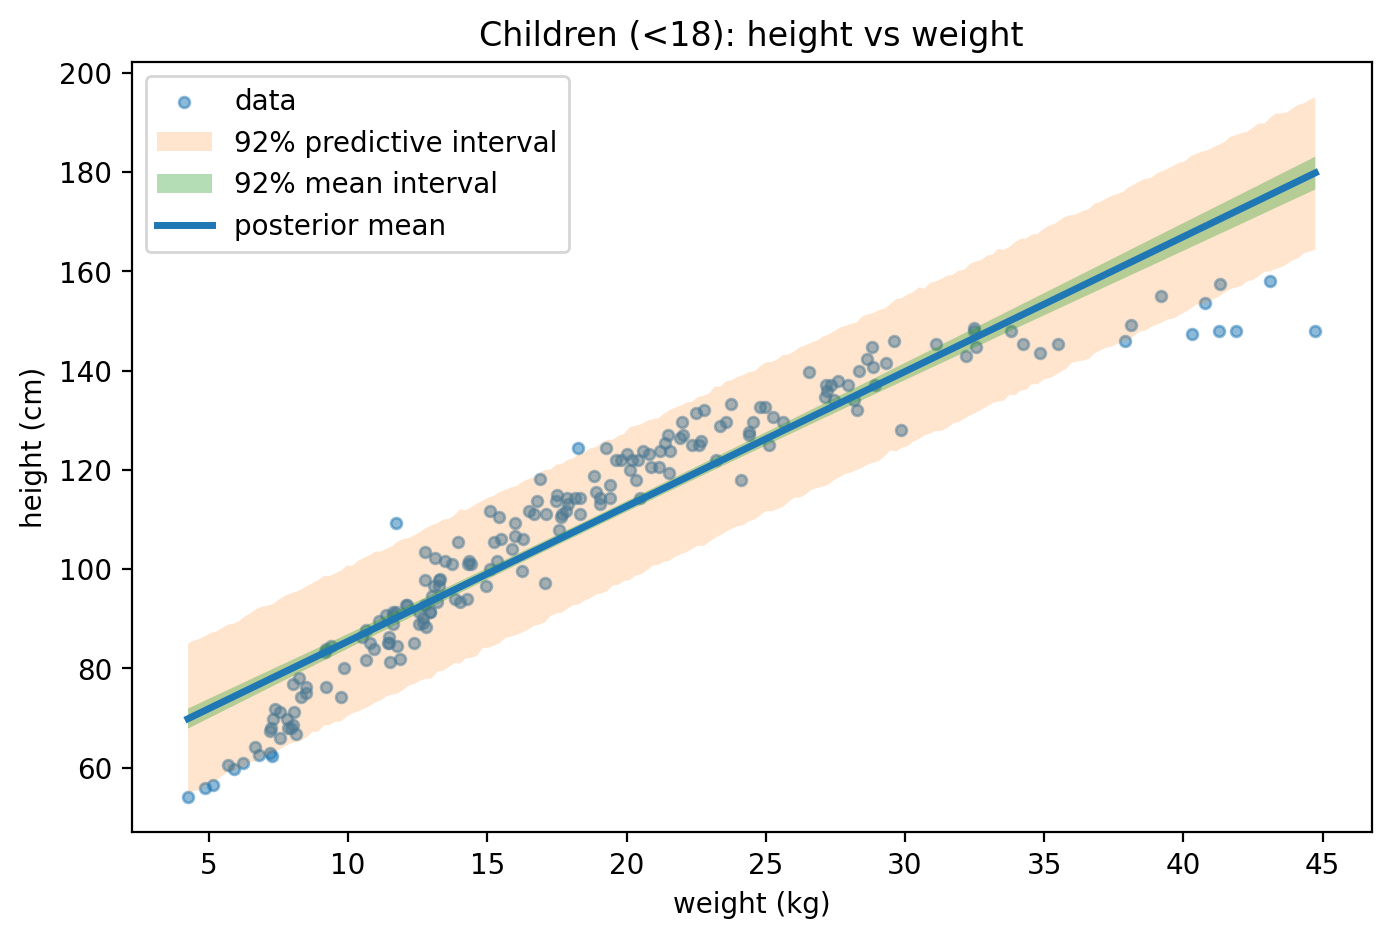

In [21]:
plt.figure()

# raw data
plt.scatter(w, h, s=15, alpha=0.5, label="data")

# predictive interval
plt.fill_between(w_grid, y_lo, y_hi, alpha=0.20, label="92% predictive interval")

# mean interval
plt.fill_between(w_grid, mu_lo, mu_hi, alpha=0.35, label="92% mean interval")

# posterior mean
plt.plot(w_grid, mu_mean, linewidth=2.5, label="posterior mean")

plt.xlabel("weight (kg)")
plt.ylabel("height (cm)")
plt.title("Children (<18): height vs weight")
plt.legend()
plt.show()


D) Model concerns & improvements


Several aspects of the model fit are concerning. First, the relationship between weight and height in children is clearly nonlinear, especially at very young ages where height increases rapidly with small changes in weight. A single straight line forces the model to compromise between infants and adolescents, leading to systematic lack of fit at the extremes.

Second, the variance in height appears to increase with weight, violating the constant-variance (homoskedasticity) assumption of the Gaussian error model.

Third, age is omitted despite being a key biological driver of growth; weight alone is an incomplete predictor for height in children.

A better model would include age explicitly, allow nonlinear growth (e.g., polynomial, spline, or log-weight models), and possibly model σ as a function of weight or age.

# Q3
Please use the code from the Week 3 notebook and modify it as necessary to answer this question.

Suppose a colleague of yours, who works on allometry, glances at the practice problems just above. Your colleague exclaims, “That’s silly. Everyone knows that it’s only the logarithm of body weight that scales with height!” Let’s take your colleague’s advice and see what happens.


# A
Model the relationship between height (cm) and the natural logarithm of weight (log-kg). Use the entire Howell1 data frame, all 544 rows, adults and non-adults.

\begin{align*}
    h_{i} &\sim \text{Normal}(\mu_{i}, \sigma) \\
    \mu_{i} &= \alpha + e^{\log{\beta}} \log(w_i) \\
    \alpha &\sim \text{Normal}(178, 20) \\
    \log(\beta) & \sim \text{Normal}(0, 1) \\
    \sigma &\sim \text{Uniform}(0, 50)
\end{align*}

# B
To check the prior, plot 100 sample curves from prior predictive simulations (see Week 4 notebook for examples). Is the prior reasonable? Do you think it should be changed? Why or why not?

# C
Approximate the posterior distribution using the MCMC approximation (using Pymc3).

# D
Create a plot with the following information (each is a function of weight)
  1. a scatter plot of the data (height vs weight)
  2. predicted mean height
  3. the 97% interval for the mean height (use `fillbetween`)
  4. the 97% interval for posterior predicted heights (use `fillbetween`)
  
Be sure to label the $x$ and $y$ axis. Make it look nice.

In [3]:
np.random.seed(123)
plt.rcParams["figure.figsize"] = (8, 5)

# --- load Howell1 (all 544 rows, adults + non-adults) ---
url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv"
df = pd.read_csv(url, sep=";")   # the file uses ';' separators :contentReference[oaicite:1]{index=1}

df.head(), df.shape

(    height     weight   age  male
 0  151.765  47.825606  63.0     1
 1  139.700  36.485807  63.0     0
 2  136.525  31.864838  65.0     0
 3  156.845  53.041914  41.0     1
 4  145.415  41.276872  51.0     0,
 (544, 4))

In [5]:
df["log_w"] = np.log(df["weight"].values)
h = df["height"].values
log_w = df["log_w"].values
w = df["weight"].values


question 3 A

In [6]:
with pm.Model() as m_logw:
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    log_beta = pm.Normal("log_beta", mu=0, sigma=1)
    beta = pm.Deterministic("beta", pm.math.exp(log_beta))  # beta > 0

    sigma = pm.Uniform("sigma", lower=0, upper=50)

    mu = alpha + beta * log_w

    h_obs = pm.Normal("h_obs", mu=mu, sigma=sigma, observed=h)


QUESTION 3(B)


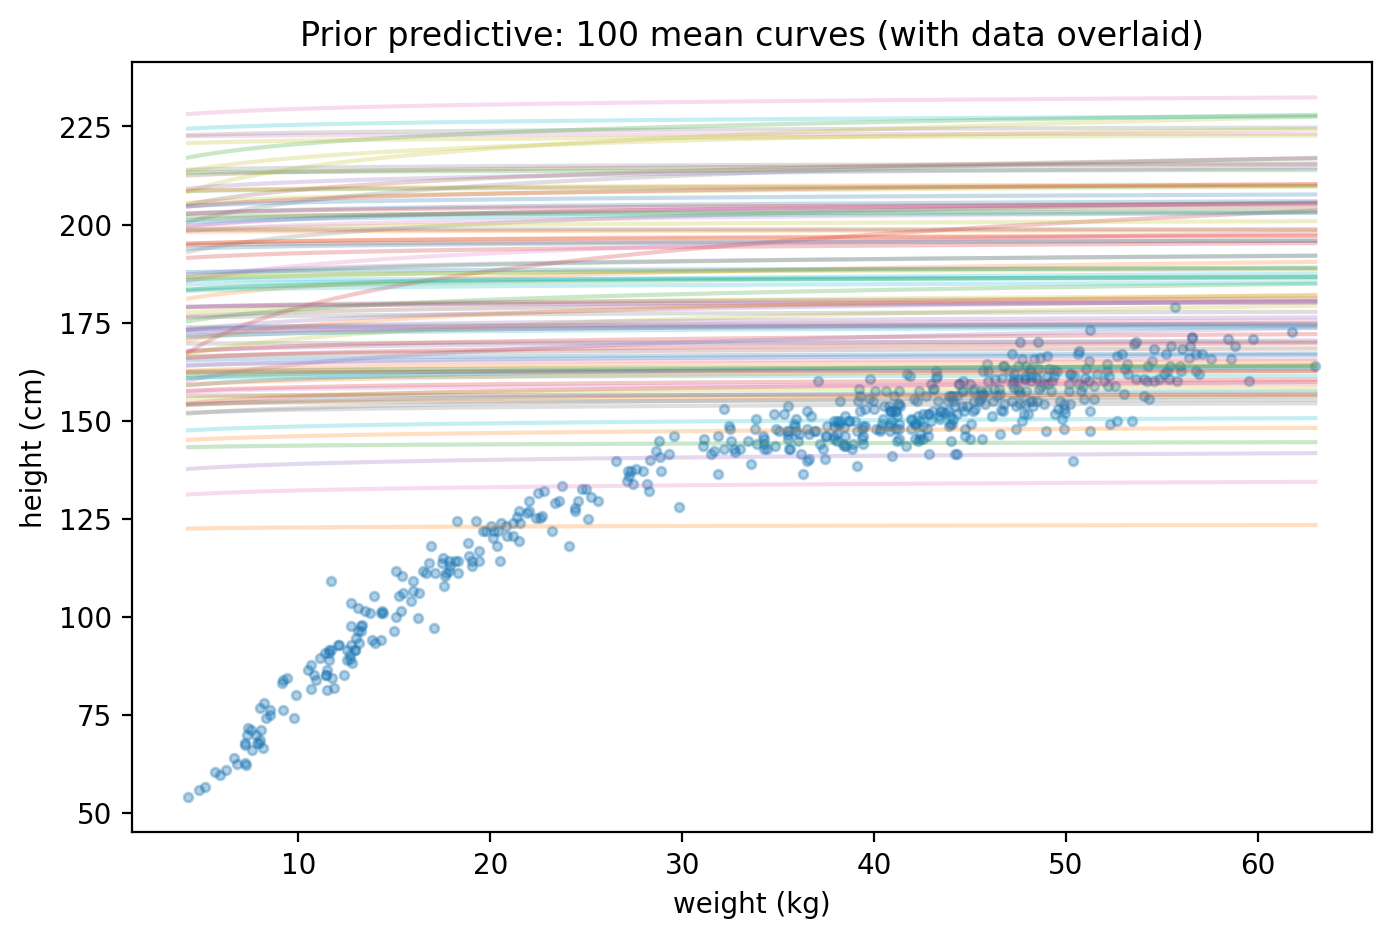

In [7]:
w_grid = np.linspace(df["weight"].min(), df["weight"].max(), 200)
log_w_grid = np.log(w_grid)

n_curves = 100
alpha_s = np.random.normal(178, 20, size=n_curves)
logbeta_s = np.random.normal(0, 1, size=n_curves)
beta_s = np.exp(logbeta_s)

plt.figure()
for i in range(n_curves):
    mu_line = alpha_s[i] + beta_s[i] * log_w_grid
    plt.plot(w_grid, mu_line, alpha=0.25)

plt.scatter(df["weight"], df["height"], s=10, alpha=0.35)
plt.xlabel("weight (kg)")
plt.ylabel("height (cm)")
plt.title("Prior predictive: 100 mean curves (with data overlaid)")
plt.show()


QUESTION 3(C)


In [8]:
with m_logw:
    trace = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        return_inferencedata=True,
        random_seed=123,
    )

az.summary(trace, var_names=["alpha", "beta", "sigma", "log_beta"])


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-22.894,1.351,-25.300,-20.227,0.027,0.019,2449.0,2907.0,1.0
beta,46.822,0.386,46.058,47.501,0.008,0.006,2484.0,2986.0,1.0
sigma,5.156,0.157,4.857,5.435,0.003,0.002,3409.0,3553.0,1.0
log_beta,3.846,0.008,3.830,3.861,0.000,0.000,2484.0,2986.0,1.0


Diagnostics / traceplots:


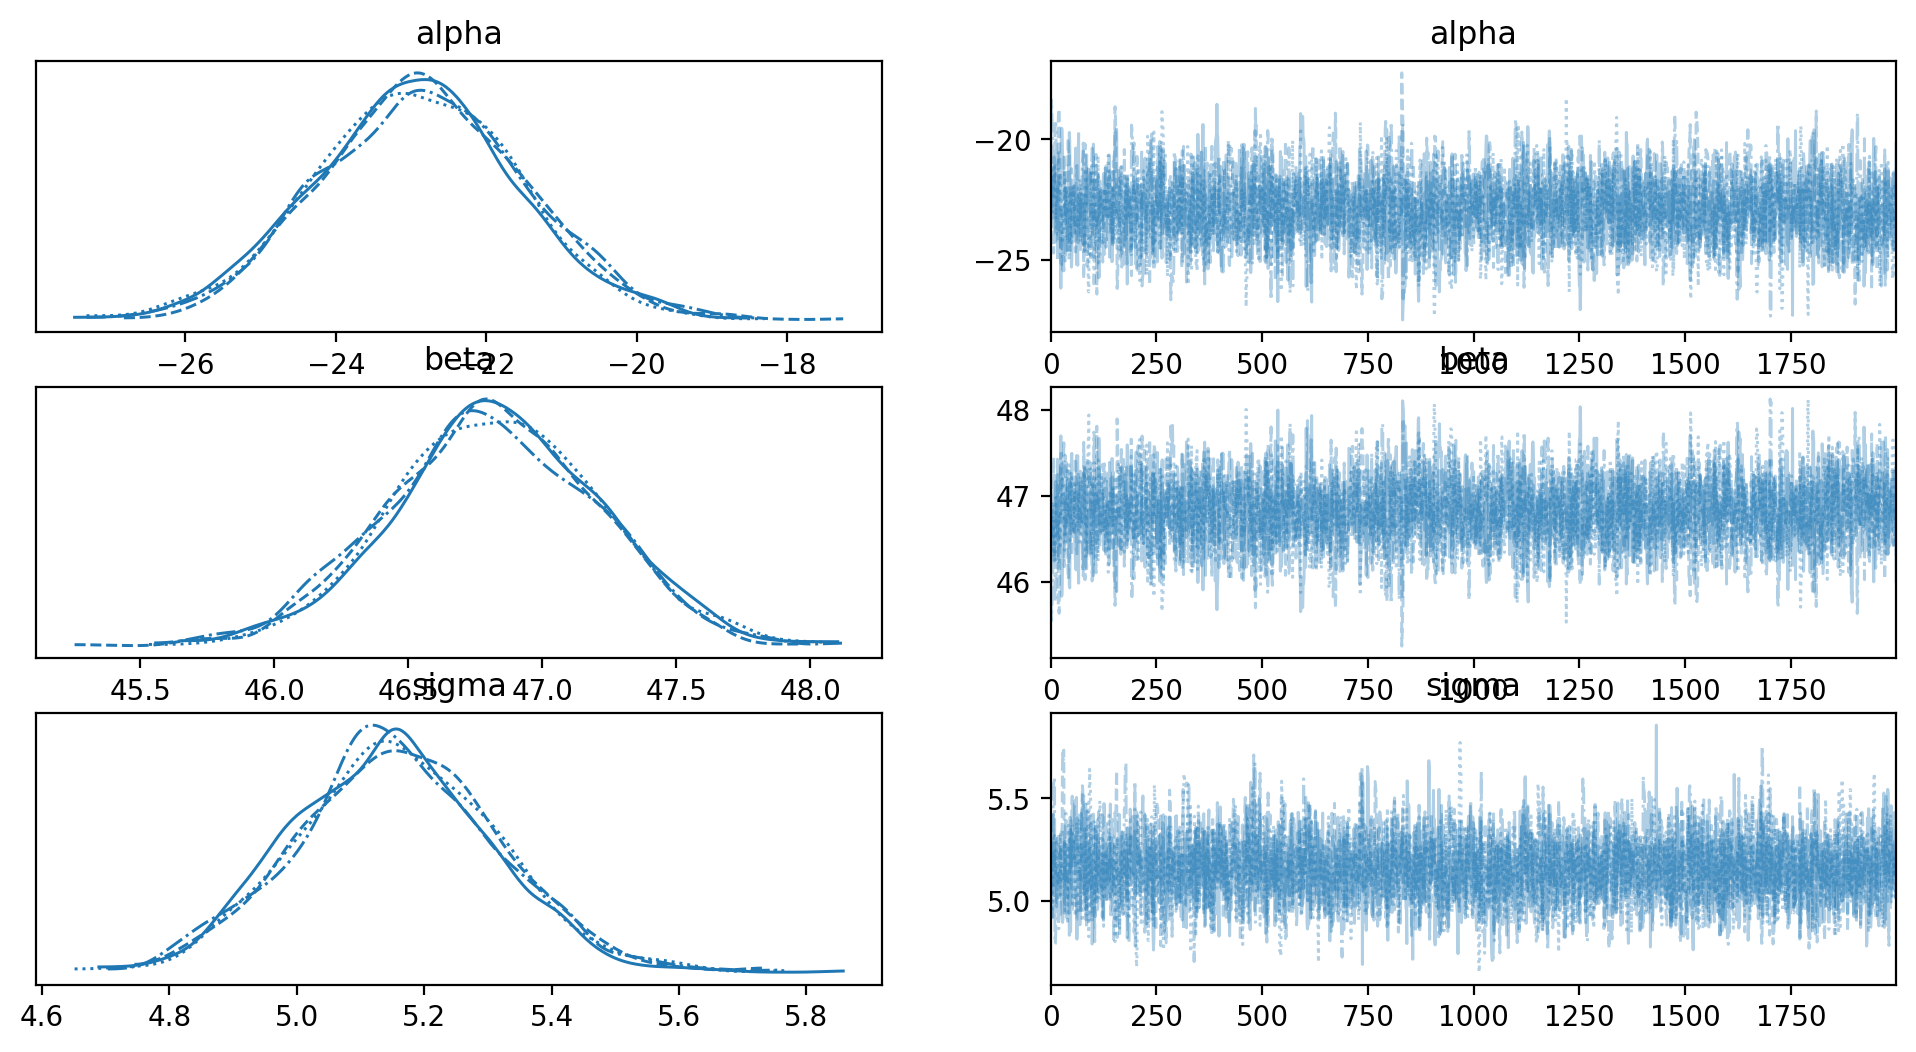

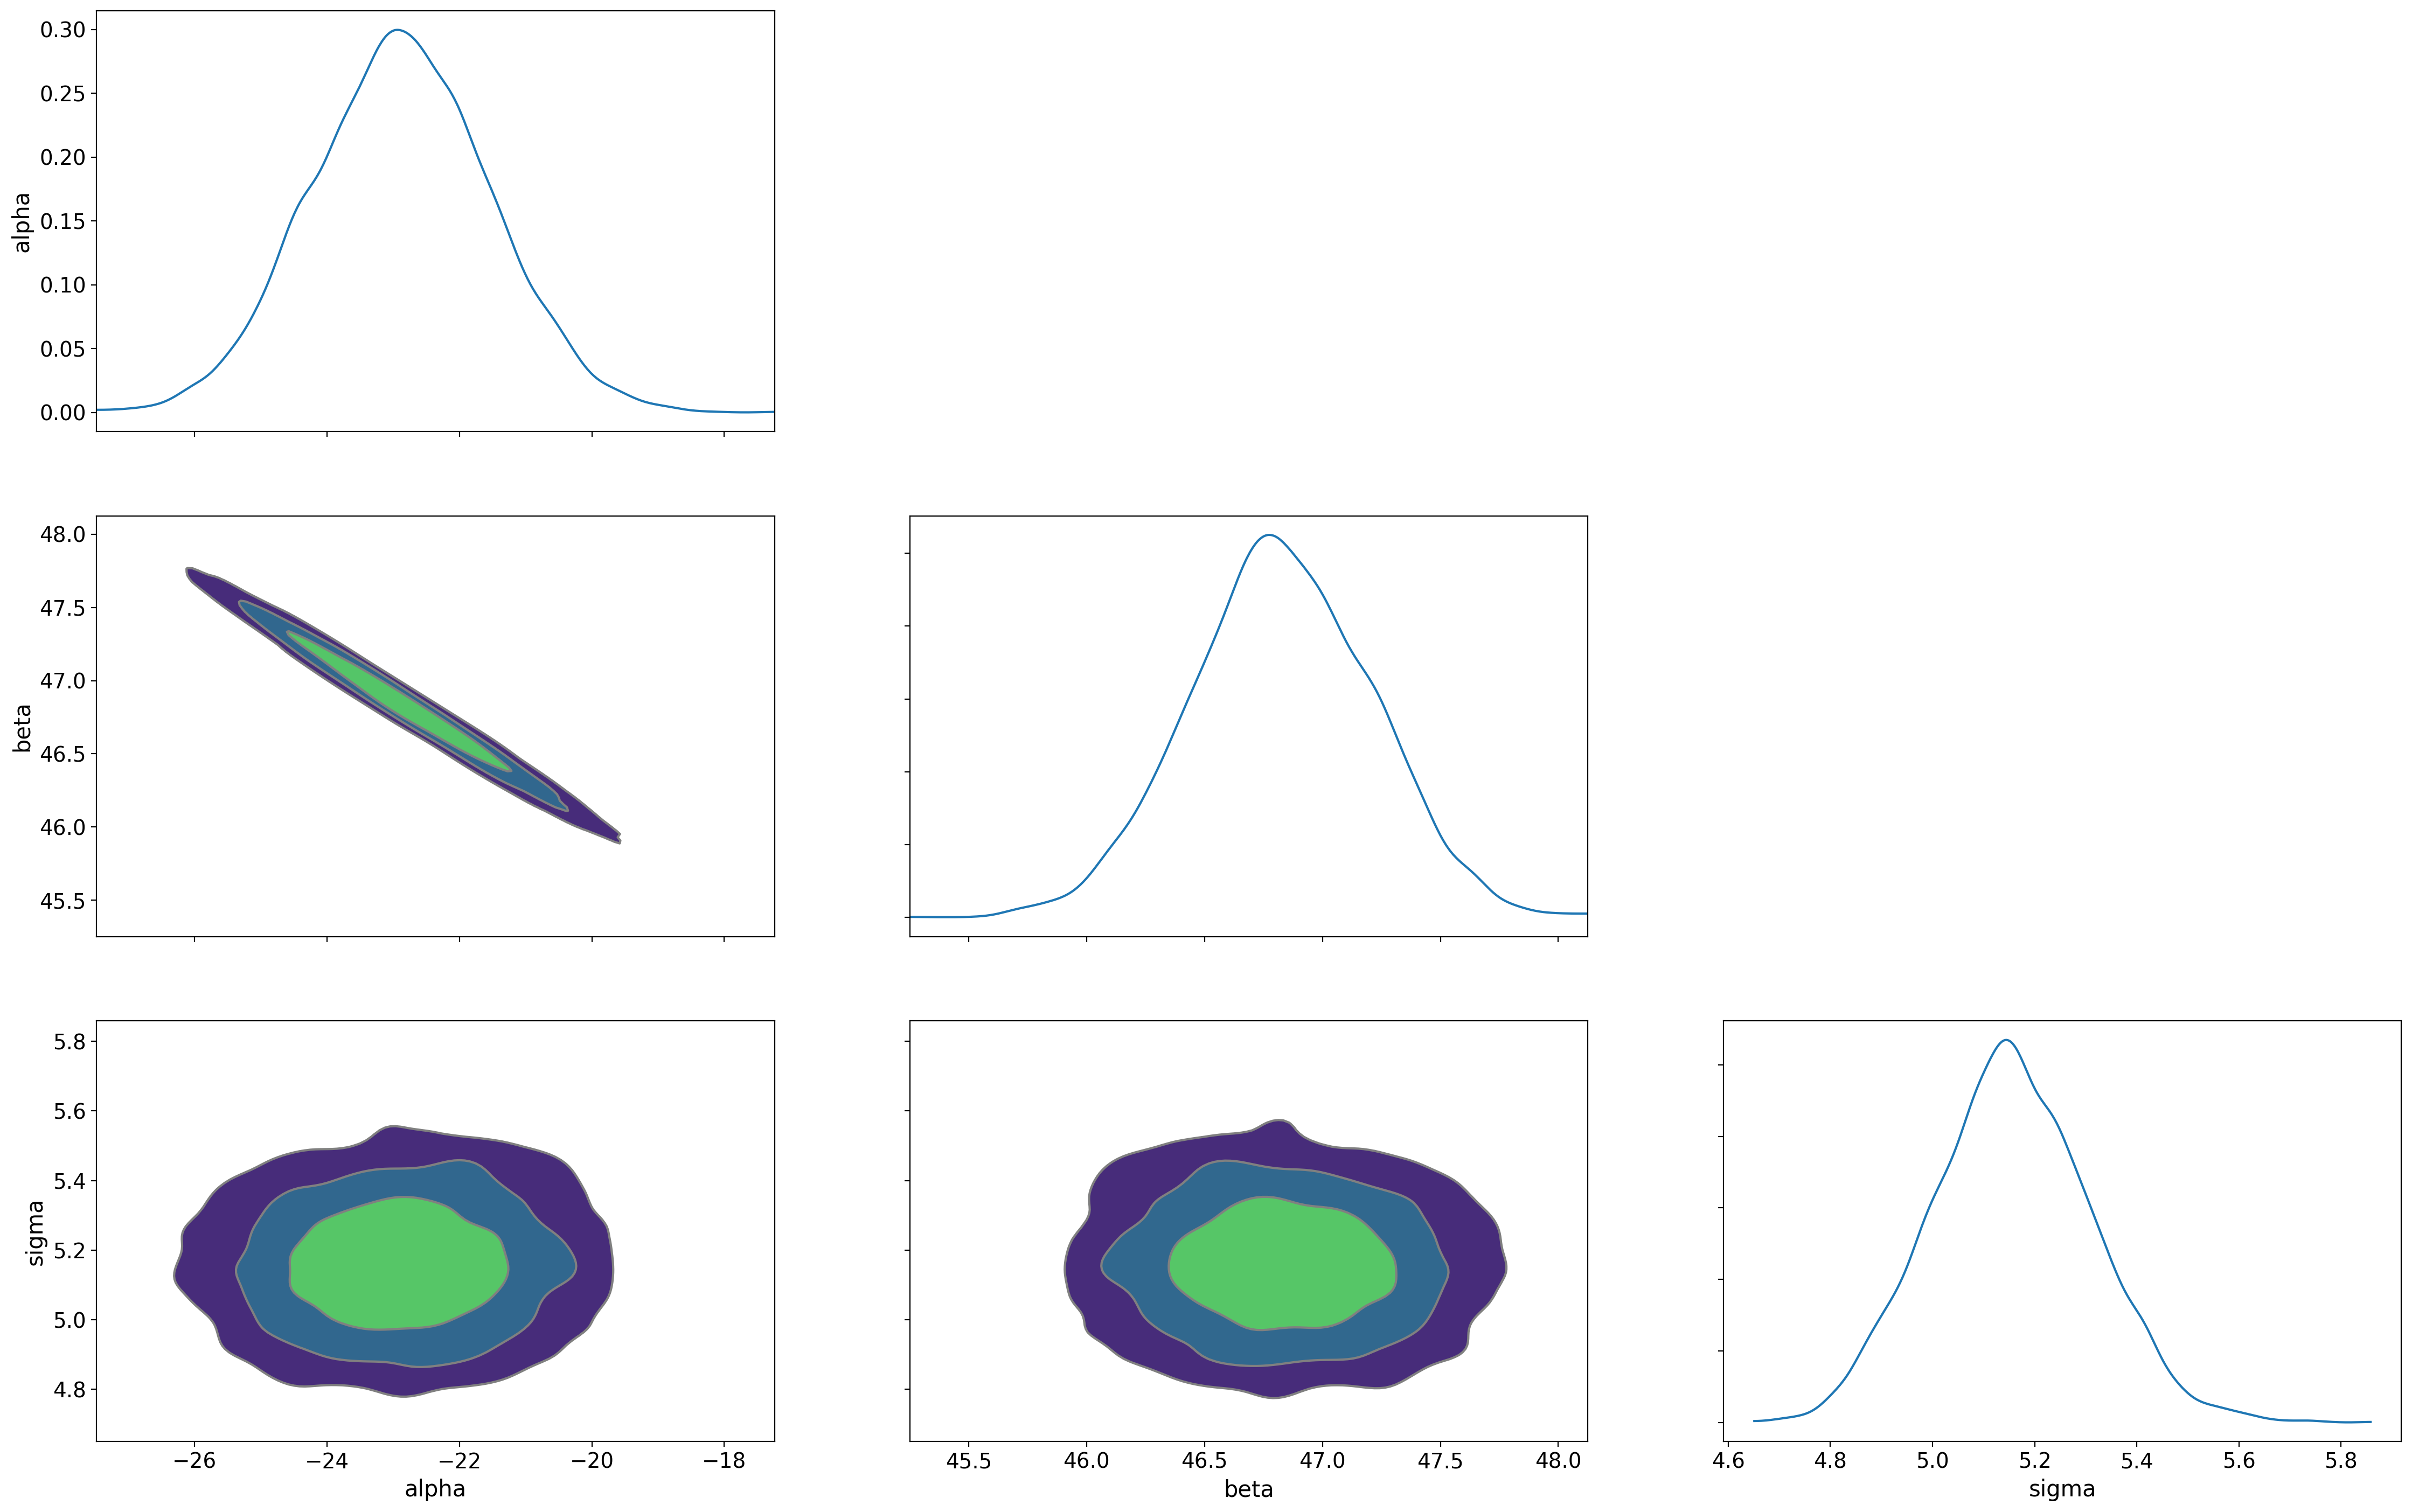

In [9]:
az.plot_trace(trace, var_names=["alpha", "beta", "sigma"]);
plt.show()

az.plot_pair(trace, var_names=["alpha", "beta", "sigma"], kind="kde", marginals=True);
plt.show()


D) Plot: data + posterior mean + 97% intervals (mean and predictive)


In [10]:
posterior = trace.posterior
alpha_draws = posterior["alpha"].values.reshape(-1)
beta_draws  = posterior["beta"].values.reshape(-1)
sigma_draws = posterior["sigma"].values.reshape(-1)

# mean function draws across grid
mu_draws = alpha_draws[:, None] + beta_draws[:, None] * log_w_grid[None, :]

# 97% interval = 1.5% to 98.5%
mu_mean = mu_draws.mean(axis=0)
mu_lo, mu_hi = np.quantile(mu_draws, [0.015, 0.985], axis=0)

# posterior predictive: draw heights around mu with sigma
# (simulate one predictive sample per posterior draw per grid point)
yrep = np.random.normal(loc=mu_draws, scale=sigma_draws[:, None])
y_lo, y_hi = np.quantile(yrep, [0.015, 0.985], axis=0)


Make the plot (with fill_between)


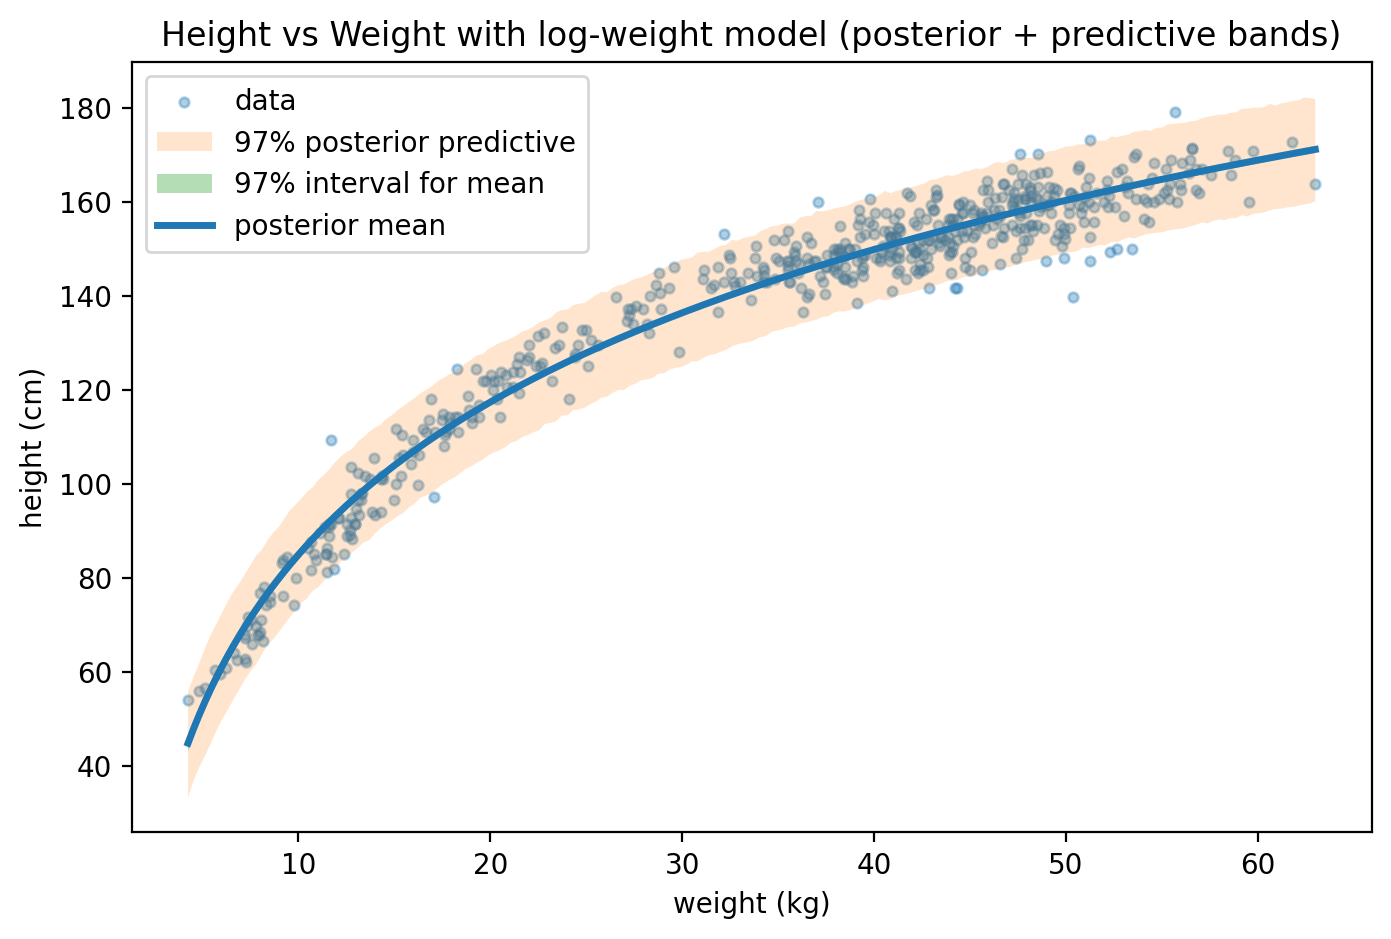

In [11]:
plt.figure()

# 1) scatter
plt.scatter(df["weight"], df["height"], s=12, alpha=0.35, label="data")

# 4) 97% interval for posterior predicted heights
plt.fill_between(w_grid, y_lo, y_hi, alpha=0.20, label="97% posterior predictive")

# 3) 97% interval for mean height
plt.fill_between(w_grid, mu_lo, mu_hi, alpha=0.35, label="97% interval for mean")

# 2) predicted mean height
plt.plot(w_grid, mu_mean, linewidth=2.5, label="posterior mean")

plt.xlabel("weight (kg)")
plt.ylabel("height (cm)")
plt.title("Height vs Weight with log-weight model (posterior + predictive bands)")
plt.legend()
plt.show()
